### Visualizing the distribution of the observations

### Load the required libraries

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
%pylab inline

import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions

### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='SBBBBBBS'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print 'keys from STAT=',STAT.keys()

#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index

df=sqlContext.read.parquet(filename)
print df.count()
df.show(5)

Populating the interactive namespace from numpy and matplotlib
keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']
12332
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|    337.4| 46.4386| -97.6856|       TMAX|USC00325220|    35|[30 D4 00 7E 00 7...|1904.0|SBBBBBBS|
|    337.4| 46.4386| -97.6856|       TMAX|USC00325220|    33|[40 4C 00 46 40 D...|1905.0|SBBBBBBS|
|    337.4| 46.4386| -97.6856|       TMAX|USC00325220|    22|[00 7E 80 D4 E0 D...|1906.0|SBBBBBBS|
|    337.4| 46.4386| -97.6856|       TMAX|USC00325220|    29|[A0 D6 00 46 30 D...|1907.0|SBBBBBBS|
|    337.4| 46.4386| -97.6856|       TMAX|USC00325220|    24|[00 7E 00 7E 00 7...|1908.0|SBBBBBBS|
+---------+--------+---------+-----------+-----------+------+-------------

### Select data for a particular station and measurement type

In [18]:
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT * FROM weather\n\tWHERE measurement='%s'"%('PRCP')
q1 = "SELECT DISTINCT station FROM weather"
q2 = "SELECT COUNT(station) AS theCount, station from weather GROUP BY station ORDER BY theCount DESC"
q3 = "SELECT COUNT(measurement) AS theCount, measurement FROM weather WHERE station='USC00324418'\
        GROUP BY measurement ORDER BY theCount DESC"
q4 = "SELECT min(latitude), max(latitude), min(longitude), max(longitude) FROM weather"
print Query
print q1
print q2
print q3
df1 = sqlContext.sql(Query)
df2 = sqlContext.sql(q1)
df3 = sqlContext.sql(q2)
df4 = sqlContext.sql(q3)
df5 = sqlContext.sql(q4)
print df1.count(),'rows'
print df2.count(), 'rows'
df1.show(2)
df4.show()
df5.show()
#df3.show(81)
rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
T=np.vstack(rows)
T=T/10.  # scaling to make the temperature be in centingrates
shape(T)

SELECT * FROM weather
	WHERE measurement='PRCP'
SELECT DISTINCT station FROM weather
SELECT COUNT(station) AS theCount, station from weather GROUP BY station ORDER BY theCount DESC
SELECT COUNT(measurement) AS theCount, measurement FROM weather WHERE station='USC00324418'        GROUP BY measurement ORDER BY theCount DESC
2927 rows
81 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|    337.4| 46.4386| -97.6856|       PRCP|USC00325220|     0|[00 00 00 00 00 0...|1904.0|SBBBBBBS|
|    337.4| 46.4386| -97.6856|       PRCP|USC00325220|     0|[00 00 00 00 00 0...|1905.0|SBBBBBBS|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 2 rows

+--------+-----------+
|theCount|measur

(2927, 365)

### Script for plotting yearly plots

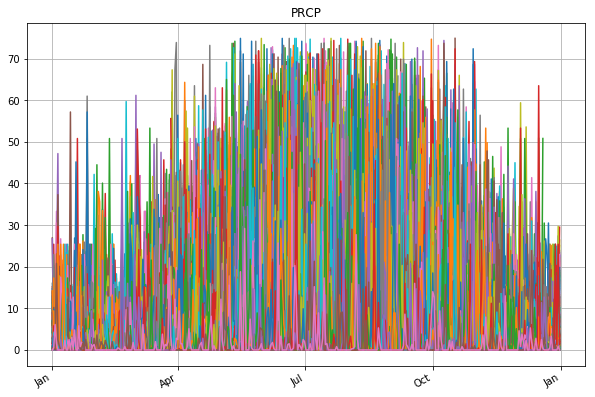

In [19]:
from YearPlotter import YearPlotter
fig, ax = plt.subplots(figsize=(10,7));
YP=YearPlotter()
YP.plot(T[:,:].transpose(),fig,ax,title='PRCP')
ax.legend().set_visible(False)
#title('A sample of graphs');

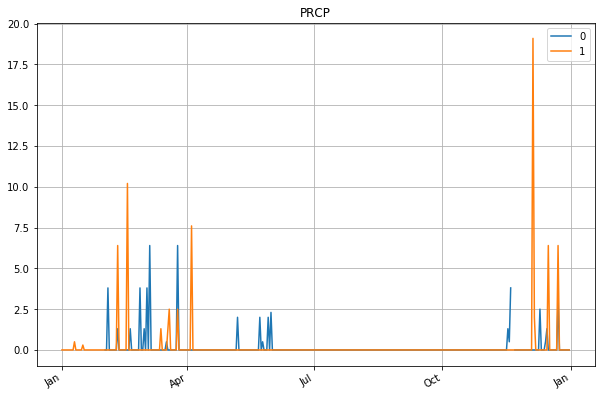

In [7]:
from YearPlotter import YearPlotter
fig, ax = plt.subplots(figsize=(10,7));
YP=YearPlotter()
YP.plot(T[:2,:].transpose(),fig,ax,title='PRCP')
#title('A sample of graphs');

### Distribution of missing observations
The distribution of missing observations is not uniform throughout the year. We visualize it below.

In [20]:
def plot_pair(pair,func):
    j=0
    fig,X=subplots(1,2,figsize=(16,6))
    axes=X.reshape(2)
    for m in pair:
        axis = axes[j]
        j+=1
        func(m,fig,axis)
        
def plot_valid(m,fig,axis):
    valid_m=STAT[m]['NE']
    YP.plot(valid_m,fig,axis,title='valid-counts '+m)
    

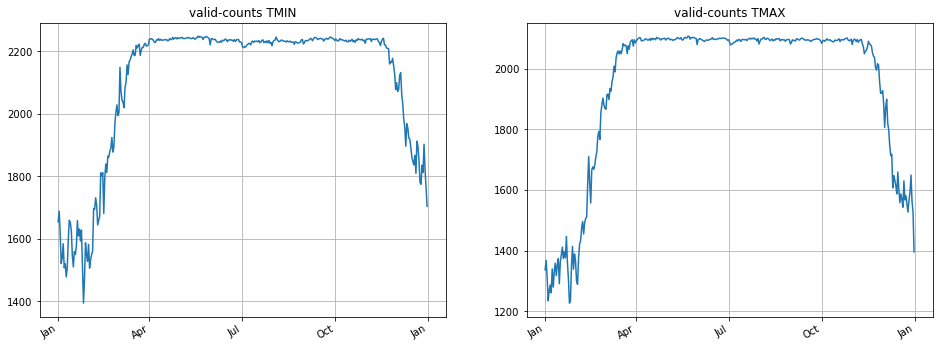

In [21]:
plot_pair(['TMIN','TMAX'],plot_valid)

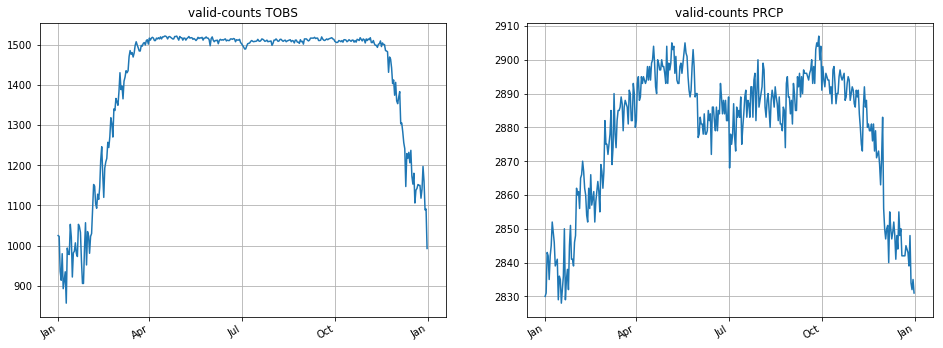

In [12]:
plot_pair(['TOBS','PRCP'],plot_valid)

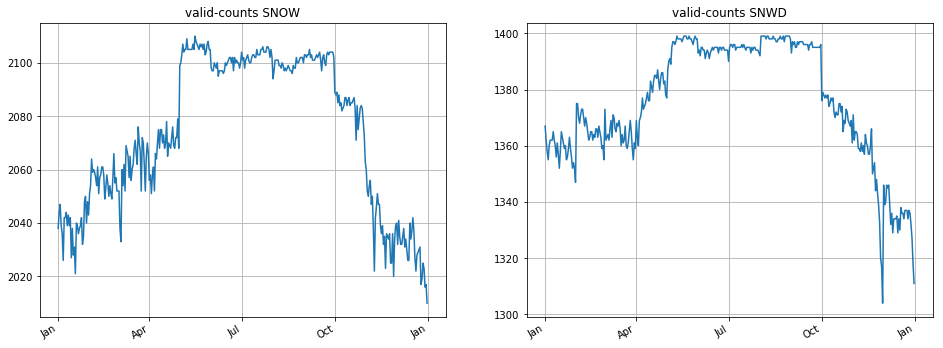

In [13]:
plot_pair(['SNOW', 'SNWD'],plot_valid)

### Plots of mean and std of observations

In [74]:
def plot_mean_std(m,fig,axis):
    DivideBy10 = ['TMIN', 'TMAX', 'TOBS']
    if m in DivideBy10:
        mean=STAT[m]['Mean']/10
        std=np.sqrt(STAT[m]['Var'])/10
    else:
        mean=STAT[m]['Mean']
        std=np.sqrt(STAT[m]['Var'])
    graphs=np.vstack([mean-std,mean,mean+std]).transpose()
    YP.plot(graphs,fig,axis,title='Mean+-std   '+m)

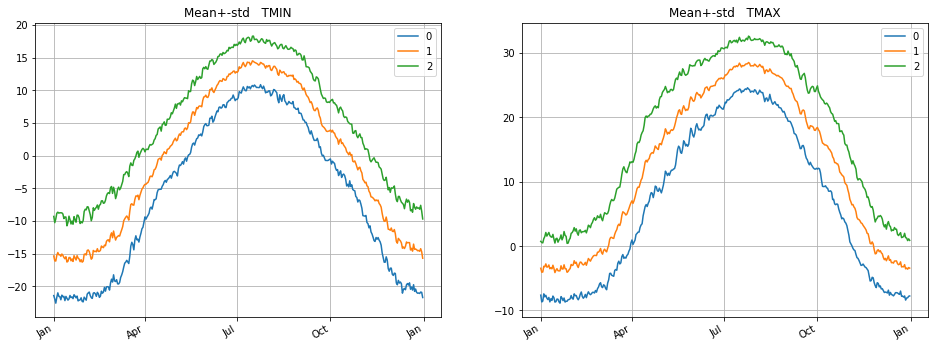

In [75]:
plot_pair(['TMIN','TMAX'],plot_mean_std)

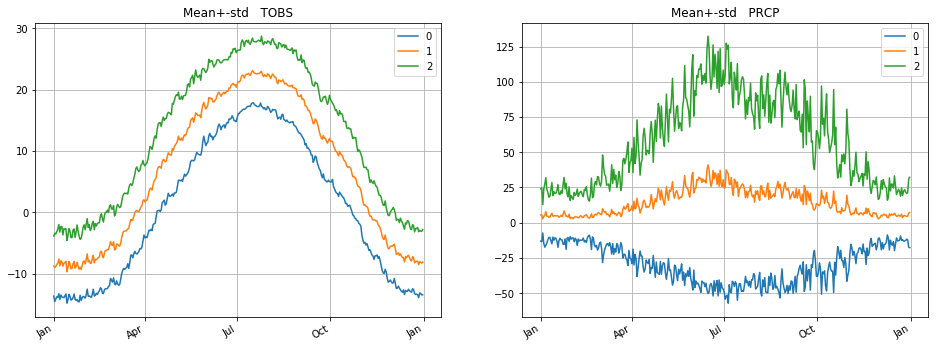

In [76]:
plot_pair(['TOBS','PRCP'],plot_mean_std)

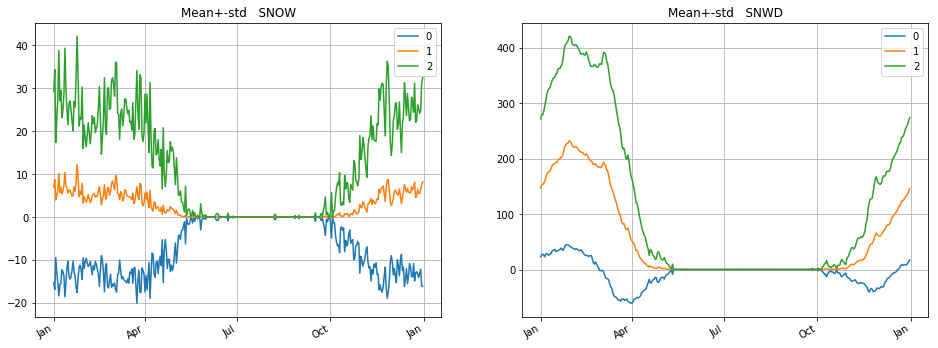

In [38]:
plot_pair(['SNOW', 'SNWD'],plot_mean_std)

### plotting top 3 eigenvectors

In [41]:
def plot_eigen(m,fig,axis):
    EV=STAT[m]['eigvec']
    YP.plot(EV[:,:3],fig,axis,title='Top Eigenvectors '+m)

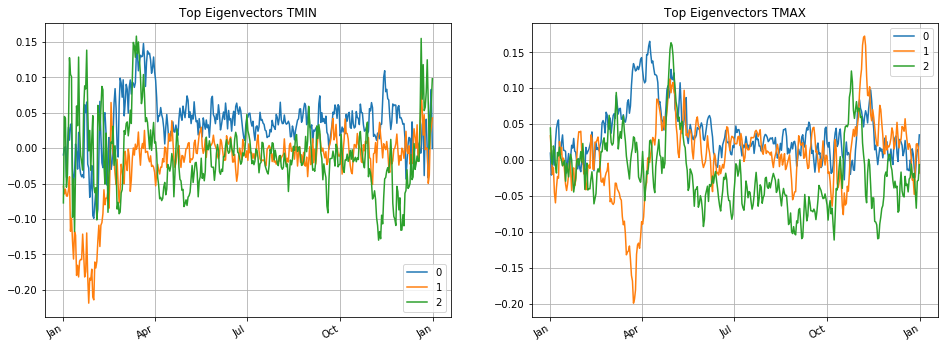

In [42]:
plot_pair(['TMIN','TMAX'],plot_eigen)

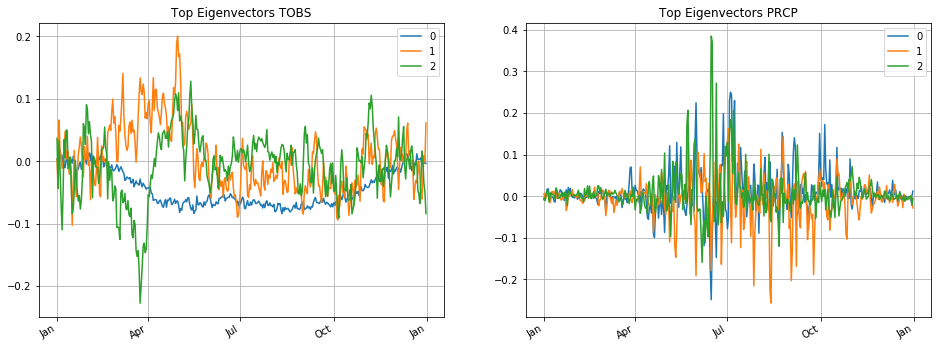

In [20]:
plot_pair(['TOBS','PRCP'],plot_eigen)

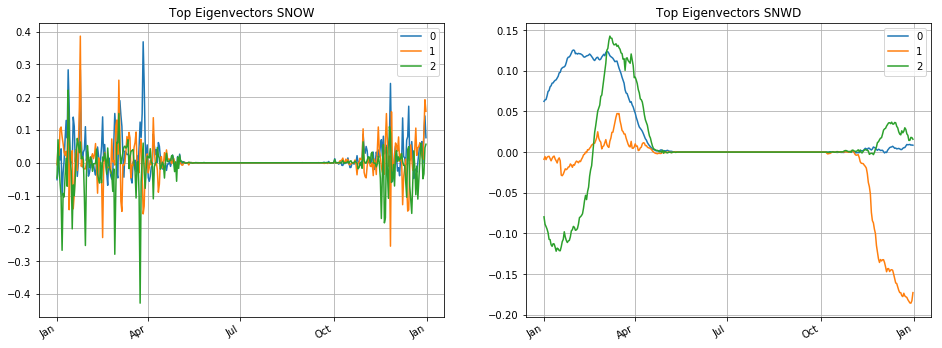

In [21]:
plot_pair(['SNOW', 'SNWD'],plot_eigen)

### Script for plotting percentage of variance explained

In [70]:
def pltVarExplained(j):
    subplot(1,3,j)
    EV=STAT[m]['eigval']
    k=5
    plot(([0,]+list(cumsum(EV[:k])))/sum(EV))
    title('Percentage of Variance Explained for '+ m)
    ylabel('Percentage of Variance')
    xlabel('# Eigenvector')
    grid()
    

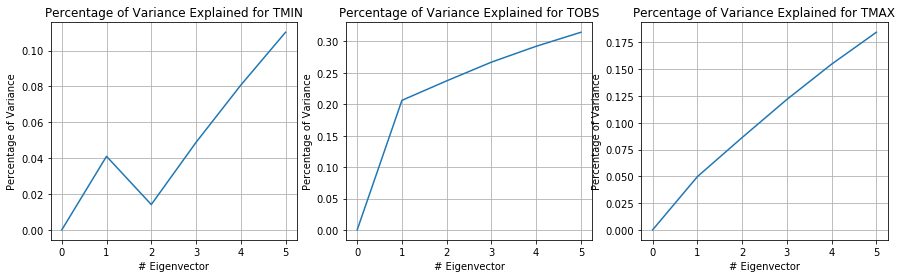

In [71]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['TMIN', 'TOBS', 'TMAX']: #,
    pltVarExplained(j)
    j+=1

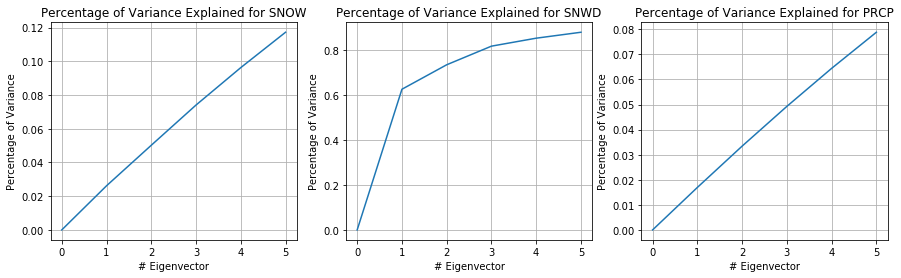

In [24]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['SNOW', 'SNWD', 'PRCP']:
    pltVarExplained(j)
    j+=1 

In [19]:
#sc.stop()

In [53]:
newCov = nearPD(STAT['TMIN']['Cov'])

In [52]:
import numpy as np,numpy.linalg

def _getAplus(A):
    eigval, eigvec = np.linalg.eig(A)
    Q = np.matrix(eigvec)
    xdiag = np.matrix(np.diag(np.maximum(eigval, 0)))
    return Q*xdiag*Q.T

def _getPs(A, W=None):
    W05 = np.matrix(W**.5)
    return  W05.I * _getAplus(W05 * A * W05) * W05.I

def _getPu(A, W=None):
    Aret = np.array(A.copy())
    Aret[W > 0] = np.array(W)[W > 0]
    return np.matrix(Aret)

def nearPD(A, nit=10):
    n = A.shape[0]
    W = np.identity(n) 
# W is the matrix used for the norm (assumed to be Identity matrix here)
# the algorithm should work for any diagonal W
    deltaS = 0
    Yk = A.copy()
    for k in range(nit):
        Rk = Yk - deltaS
        Xk = _getPs(Rk, W=W)
        deltaS = Xk - Rk
        Yk = _getPu(Xk, W=W)
    return Yk

In [62]:
print newCov.shape, STAT['TMIN']['']

(365, 365)


In [55]:
newEigenValues, Vectors =np.linalg.eig(newCov)

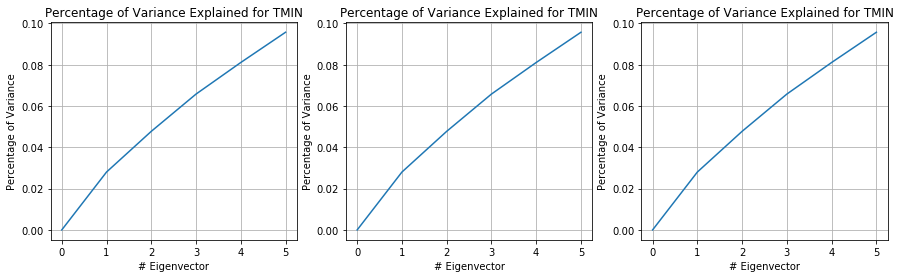

In [77]:
def pltVarExplained(j):
    subplot(1,3,j)
    EV=newEigenValues
    k=5
    plot(([0,]+list(cumsum(EV[:k])))/sum(STAT[m]['eigval']))
    title('Percentage of Variance Explained for '+ m)
    ylabel('Percentage of Variance')
    xlabel('# Eigenvector')
    grid()
    
f=plt.figure(figsize=(15,4))
j=1
for m in ['TMIN', 'TMIN', 'TMIN']:
    pltVarExplained(j)
    j+=1 

In [21]:
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT * FROM weather\n\tWHERE measurement='%s' AND station='%s'"%('SNWD', 'USC00218579')
#q1 = "SELECT count(station) as theCount, station FROM weather\n\tWHERE measurement='SNWD' GROUP BY station ORDER BY theCount DESC"
#df2 = sqlContext.sql(q1)
#print df2.show()
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(2)
#df3.show(81)
rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
T=np.vstack(rows)
#T=T/10.  # scaling to make the temperature be in centingrates
shape(T)

yearlyRainfall = [np.nansum(T[i]) for i in range(len(T))]
#yearlyRainfall = [i for i in yearlyRainfall if i > 7000]
year = range(1919, 2011)

68 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|    418.2| 46.3939| -95.1494|       SNWD|USC00218579|    31|[00 7E 00 7E 00 7...|1919.0|SBBBBBBS|
|    418.2| 46.3939| -95.1494|       SNWD|USC00218579|    34|[00 00 00 00 00 0...|1926.0|SBBBBBBS|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 2 rows



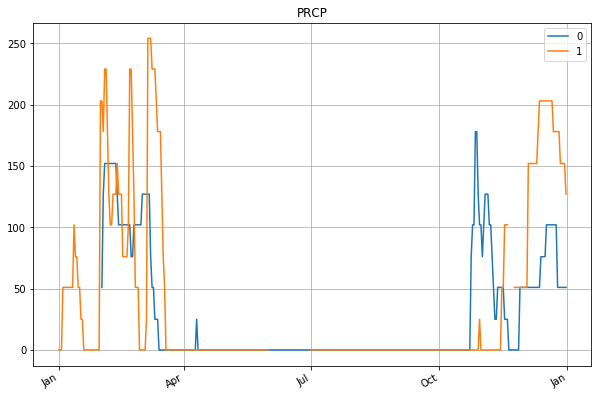

In [22]:
from YearPlotter import YearPlotter
fig, ax = plt.subplots(figsize=(10,7));
YP=YearPlotter()
YP.plot(T[:2,:].transpose(),fig,ax,title='PRCP')
#title('A sample of graphs');

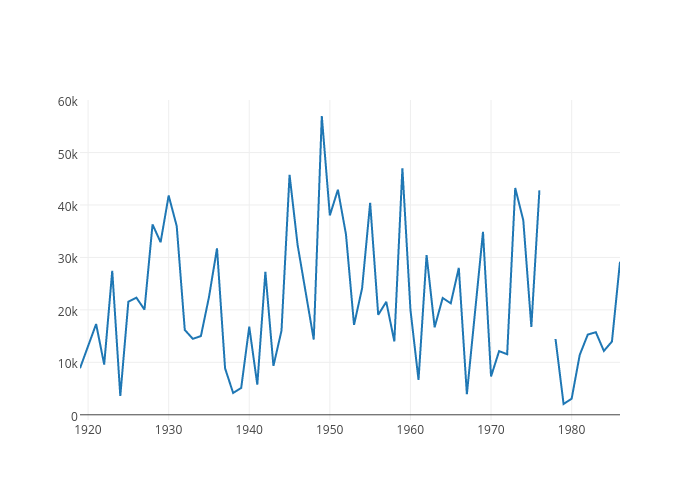

In [23]:
import plotly.plotly as py
import plotly.graph_objs as go

from datetime import datetime

data = [go.Scatter(
            x=year,
            y=yearlyRainfall)]

py.iplot(data)

In [125]:
import plotly 
plotly.tools.set_credentials_file(username='sharmakeshav7', api_key='57we4tFWpJNI8I7rqNzi')

In [132]:
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT * FROM weather\n\tWHERE measurement='%s' AND station='%s'"%('TOBS', 'USC00216276')
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(2)
#df3.show(81)
rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
T=np.vstack(rows)
#T=T/10.  # scaling to make the temperature be in centingrates
shape(T)

print T[0]

39 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|    298.7| 46.4314| -95.5464|       TOBS|USC00216276|    48|[80 D1 80 49 00 4...|1962.0|SBBBBBBS|
|    298.7| 46.4314| -95.5464|       TOBS|USC00216276|    31|[00 D3 80 CD A0 D...|1963.0|SBBBBBBS|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 2 rows

[ -44.   11.   28.  -56.   nan -111. -139.   nan   nan   nan  -33.  -89.
  -78. -111.   nan   nan   nan   nan   nan   nan   nan -133.  -83.   11.
   -6. -156.   nan  -78.  -89. -139. -117. -122.   11.   33. -122.   nan
   nan   nan -150. -117.  -50.  -17.   nan    0.   nan  -11. -150.   nan
 -111. -122. -128. -122. -117. -106. -111. -150.   nan   nan   nan   nan
  -94.  